## Analyse von Verkaufsdaten inkl. Umsatzvorhersagen

In dieser Analyse wurden Verkaufsdaten untersucht und ein Vorhersagemodell zur Prognose von Umsätzen entwickelt. Der Fokus lag auf der Implementierung eines Random Forest-Modells, das durch umfangreiches Feature Engineering und eine sorgfältige Evaluierung optimiert wurde. Die wichtigsten Ergebnisse sind:

Vor allen Zeitbasierte Features trugen wesentlich zur Verbesserung der Modellgenauigkeit bei, indem sie saisonale Muster und Trends in den Verkaufsdaten erfassten. Zur Auswahl der Features trug ausßerdem eine Korrelationsmatrix bei, als stärkste predikatoren auf dei Zielvariable (Sales) konnten die Kundenanzahl, der Wochentag und die Promotionseffekte identifiziert werden.

Mittels Radnom Forest konnte zeite  mit einem Trainings-RMSE von 943.99 und einem Test-RMSE von 946.23 seht gute pefomance im Hinblick auf dei Umsatzvorhersagen. Der minimale Unterschied zwischen Trainings- und Testmetriken (RMSE-Differenz: 2.25, R²-Differenz: 0.0001) zeigt, dass das Modell gut generalisiert und keine Anzeichen von Overfitting aufweist.
Damit ist das Modell einsatzbereit im Sinne einer präzisen Vorhersageleistung. Mit einem Test-R^2 von 0.94 kann es dabei unterstützen, fundierte Entscheidungen in Bezug auf Lagerhaltung, Marketing und Ressourcenplanung zu treffen.

# Part 0: Headder, Daten einlesen und erster Überblick

Bibliotheken importieren und Datensatz einlesen um einen Überblick über die Struktur der Daten zu verschaffen.
Nach der Ausführung des Codes zeigt sich, dass es im Store Set viele fehlende Werte gibt, die wir adressieren müssen. Außerdem sollten 
Strings in numerische Werte konvertiert werden.


In [ ]:
## Headder imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')



# Source
train_df = pd.read_csv('train.csv')
store_df = pd.read_csv('store.csv')


#print(train_df.info())
#print(train_df.head())
#print(store_df.info())
#print(store_df.head())

#print(train_df.isnull().sum())
#print(store_df.isnull().sum())

# Part 1: Daten vorbereiten und bereinigen

## To Do:
- Datumsewrte als Strings -> müssen konvertiert werden 
- StateHiliday von Object in kategorische Variable
- fehlende Werte müssen adressiert werden -> hier gibt es mehrere Möglichkeiten (Mean, Median, Nullen)
- Umsätze von täglich -> Wöchentlich (2)

## Überlegung für fehlende Werte:
Keine Angabe zu Wettbewerbern bedeutet, dass es keine Konkurenz gab/gibt. Oder ganz altes Datum einfügendamit die Werte nicht mit neuen und tatsächlichen Stores verwechselt werden. Würde man bspw. mit Median füllen würden die gegebenheiten vor Ort verwässen und die interpretierbarkeit wäre unschärfer. Fehlende Werte bei CompetitionDistance können wiederum repräsentativ mit Median gefüllt werden  

In [ ]:
###########################################################Datenbereinigung
## Date als datetime formatieren
train_df['Date'] = pd.to_datetime(train_df['Date'])

## String der holiday als Variable speichern
train_df['StateHoliday'] = train_df['StateHoliday'].astype('category')

## fehlende Werte mit Median auffüllen
store_df['CompetitionDistance'] = store_df['CompetitionDistance'].fillna(
    store_df['CompetitionDistance'].median())

# Zeitangaben bei cometitors -> wenn keine Angabe, dann keine konkurrenz
store_df['CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(0)
store_df['CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(0)

### hier genauso, wenn keine Daten dann gab es auch keine Promo2
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(0)
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(0)
store_df['PromoInterval'] = store_df['PromoInterval'].fillna('None')

## Asugabe der Daten -> fallen Ausreißer oder unplausible auf?
#print("\nInfo Train:")
#print(train_df.info())
#print("\ninfo store:")
#print(store_df.info())
#print("\nStatistik ausgeben:")
#print(train_df.describe())

In [ ]:
####woche und jahr aus Datum extrahieren (wir wollen ja wöchentliche Vorhersagen machen)...
train_df['Year'] = train_df['Date'].dt.year
train_df['Week'] = train_df['Date'].dt.isocalendar().week

# ... und wöchentliche Aggregation
weekly_sales = train_df.groupby(['Store', 'Year', 'Week']).agg({
    'Sales': 'sum',
    'Customers': 'sum',
    'Open': 'sum',
    'Promo': 'mean',
    'SchoolHoliday': 'mean'
}).reset_index()

# wöchentliche Daten ausgeben
weekly_sales['AvgDailySales'] = weekly_sales['Sales'] / weekly_sales['Open']
weekly_sales['AvgDailyCustomers'] = weekly_sales['Customers'] / weekly_sales['Open']
weekly_sales['SalesPerCustomer'] = weekly_sales['Sales'] / weekly_sales['Customers']

print("\nStats zu wöchentlichen Daten")
print(weekly_sales.describe())
print(weekly_sales.groupby('Store').size().describe())
print(weekly_sales.head())

## Umsatzdaten wöchentlich darstellen...

## dabei fällt auf:
- Daten erstrecken sich von 2013 bis 2015
- durchschnittlich 131 Wochen pro Filiale
- durchscnittliche Verkäufe pro Tag varriieren
- SalesPerCustomer 9,54€, aber mit großer Spreizung von 0 bis 26€
- Kundenfrequenz (AvgDailyCustomers) 760 Kund*innen pro Tag, wieder mit großer Varianz (Stdev 371 Kunden)
- Ausreißer eiiger Filialen von 4300 Kunden pro Tag
- Deutliche Unterschiede bei den verschiednenen Ladenmodellen -> große Spreizung bei der Kundenfrequenz deutet auf unterschiedliche Standortqualitäten hin
- Spanne bei den Umsätzen (7,99-10,93) deutet auf Optimierungspotenzial hin


# Part 3: EDA 
## Daten weiter Aufbereiten und erste Visualisierung

In [ ]:
################################################# Erste aufbereitung und Visualisirung
### Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

## Mean der wöchentlichen Sales
weekly_avg_sales = weekly_sales.groupby(['Year', 'Week'])['Sales'].mean().reset_index()
ax1.plot(range(len(weekly_avg_sales)), weekly_avg_sales['Sales'])
ax1.set_title('Wöchentliche Verkäufe (avg)')
ax1.set_xlabel('Wochen')
ax1.set_ylabel('Verkäufe')

# verkäufe pro Kunde
ax2.hist(weekly_sales['SalesPerCustomer'].dropna(), bins=30)
ax2.set_title('Verkäufe vs. Kunden')
ax2.set_xlabel('Anzahl Kunden')
ax2.set_ylabel('Häufigkeit')

# Mean Verkäufe nach Wochentag
daily_sales = train_df.groupby('DayOfWeek')['Sales'].mean()
ax3.bar(daily_sales.index, daily_sales.values)
ax3.set_title('Verkäufe nach Wochentag')
ax3.set_xlabel('Wochentag')
ax3.set_ylabel('Durchschnittliche Verkäufe')

#verkäufe vs. Kunden
ax4.scatter(weekly_sales['Customers'], weekly_sales['Sales'], alpha=0.1)
ax4.set_title('Verkäufe pro Kunde (€)')
ax4.set_xlabel('Anzahl Kunden')
ax4.set_ylabel('Verkäufe')

plt.tight_layout()
plt.show()

print("\nKennzahlen:")
summary_stats = weekly_sales[['Sales', 'Customers', 'SalesPerCustomer']].describe().round(2)
print(summary_stats)

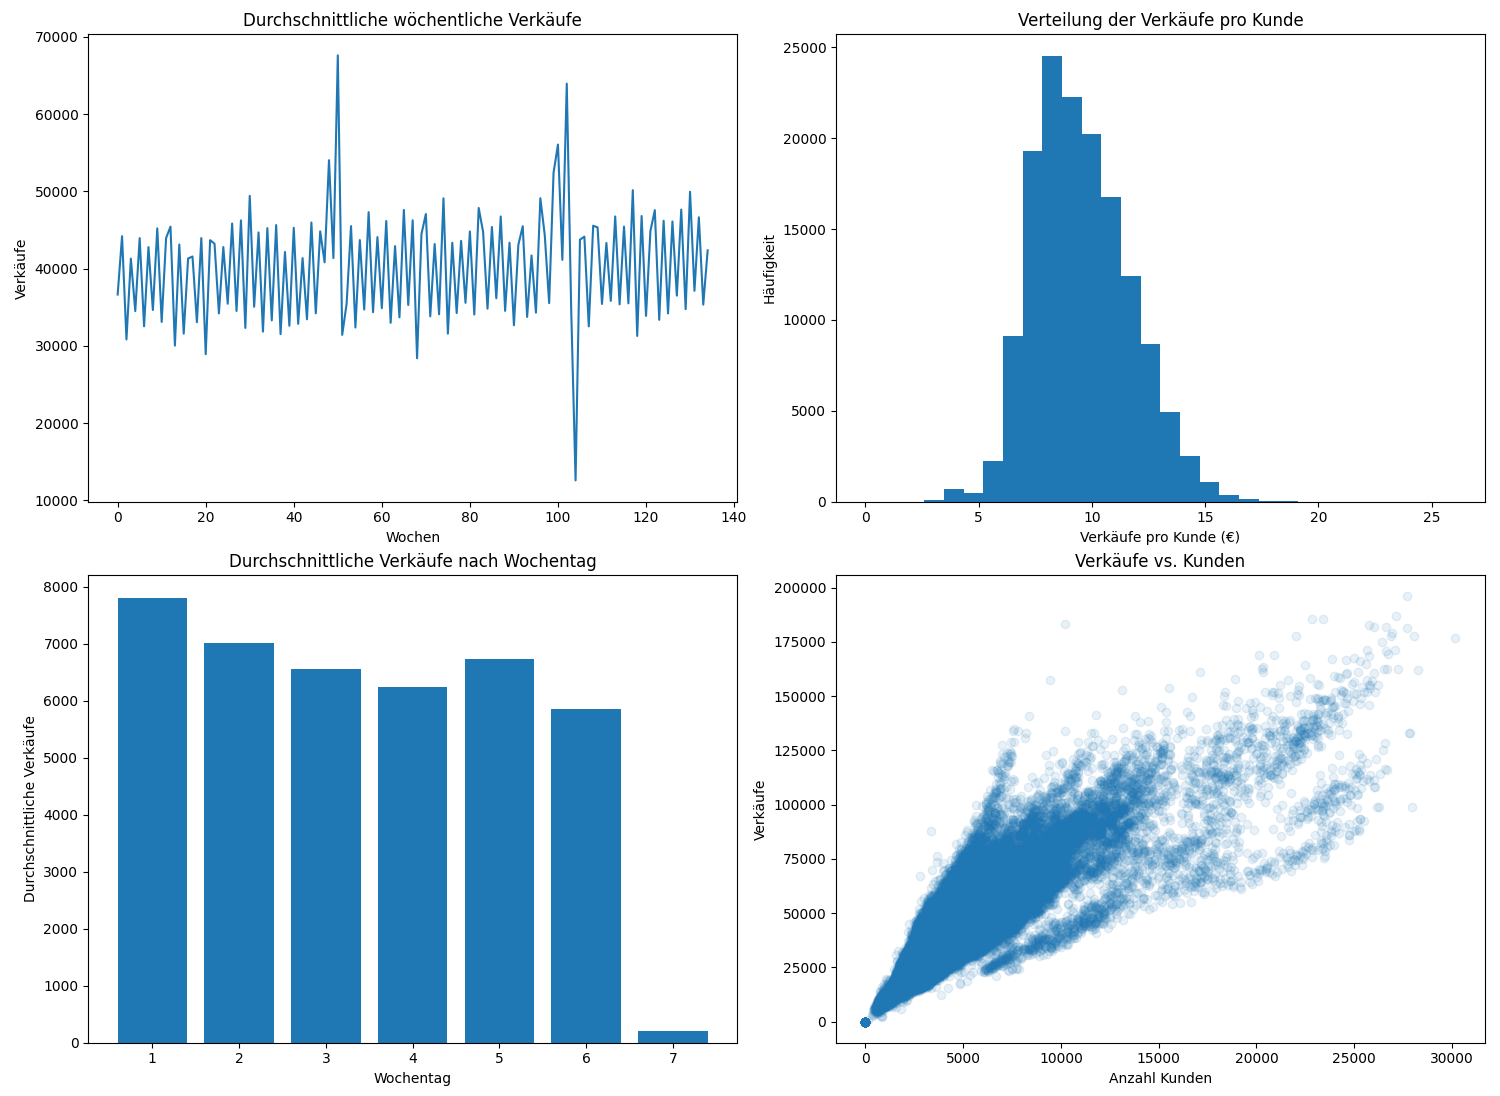

## Beobachtungen:

Zeitliche Komponenten und Trends bei den wöchentlihcen Verkäufen:
- starke wöchentliche Schwankungen im Beriech zwischen 30k bis 70k
- wobei zwei Ausreißer mit 65k€ (Woche 60 und 100), gefolgt von zweitem Ausreißer nach unten unmittelbar danach
- Überlegung: Schwankungen durch saisonale Effekte, Feiertage oder Promotions??
- To Do: Analyse auf Wochenbasis um Spitzen und Einbrüche besser einordnen zu können, mit Feiertagen und Ferien könnte schwierig werden

Verkäufe pro Kund*in:
- Normalverteilt im Bereich um 8-11€ (Mean 9,54)
- Verteilung stabil um den Median mit weenigen Ausreißern >20€
- To Do: Ursache für Ausreißer verstehen (Promotions, große Einkäufe ...)

Muster in den Wochentagen:
- Montags hat dei höchsten durchschnittswerte
- Dienstag und Freitag stechen auch nochmal hervor
- sonst fast kontinuierliher Rückgang (und Sonntag zu - eh klar)
- Handlungsempfehlung: Fokus auf umsatzstarke Tage mit gezielten Marketingaktionen und Promotions
- Außerdem liefert das Wochentagsmuster Implikationen für Personalplanung

Korrelation Verkäufe vs Kunden
- korreloiert stark Positiv
- aber Streuung mit steigender Kundenzahl
- Maximum Kundenzahl bei ca. 30k/Woche
- Maximale Umsatz 195930€/Woche
- To Do: Filialen mit Überdurchschittlicher Verkaufsleistunfg der Kunden analysieren und Strategien ableiten für Best-Practice


## Zusammenfassung:
- Durchscnuttlicher Umsatz pro Woche 40220€ (Stdev 16763€)
- Durchschnittliche Kundenzahl prop Woche 4410 (Stdev 2359)
- Durschnittlicher Umsatz/Kunde 9,54€ (mit Stev 2,10€)
- Streuung bei den Verkäufen und Kundenanzahlen deutet auf signifikante Unterschiede zwischen den Filialen hin
- Analyse der Top- und Low-Performer, um Optimierungspotenziale zu identifizieren
- Verkaufsspitzen folgen Saisonalem Muster?
- Effekt von Prommotions untersuchen

# 3.1 Ladenmodelle

In [ ]:
########################################### Performance der Ladenmodelle

# Targets festlegen, es geht ja um die Verkäufe -> Store-Daten mit Verkaufsdaten verbinden
store_performance = weekly_sales.merge(store_df[['Store', 'StoreType', 'Assortment']], on='Store')

### plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

#
store_type_sales = store_performance.groupby('StoreType')['Sales'].mean().sort_values(ascending=False)
ax1.bar(store_type_sales.index, store_type_sales.values)
ax1.set_title('Verkäufe nach Filialtyp')
ax1.set_ylabel('Durchschnittliche Verkäufe')

#
store_type_spc = store_performance.groupby('StoreType')['SalesPerCustomer'].mean().sort_values(ascending=False)
ax2.bar(store_type_spc.index, store_type_spc.values)
ax2.set_title('Verkäufe pro Kunde nach Filialtyp')
ax2.set_ylabel('€ pro Kunde')

#
promo_effect = store_performance.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack()
promo_effect['Steigerung_%'] = ((promo_effect[1] - promo_effect[0]) / promo_effect[0] * 100).round(1)
ax3.bar(promo_effect.index, promo_effect['Steigerung_%'])
ax3.set_title('Promotions-Effekte nach Filialtyp')
ax3.set_ylabel('Verkaufssteigerung in %')

#
store_type_customers = store_performance.groupby('StoreType')['Customers'].mean().sort_values(ascending=False)
ax4.bar(store_type_customers.index, store_type_customers.values)
ax4.set_title('Kundenanzahl nach Filialtyp (avg)')
ax4.set_ylabel('Kundenanzahl')

plt.tight_layout()
plt.show()

print("\nZusammenfassung nach Filialtyp:")
summary_stores = store_performance.groupby('StoreType').agg({
    'Sales': ['mean', 'std'],
    'Customers': 'mean',
    'SalesPerCustomer': 'mean',
    'Promo': 'mean'
}).round(2)
print(summary_stores)

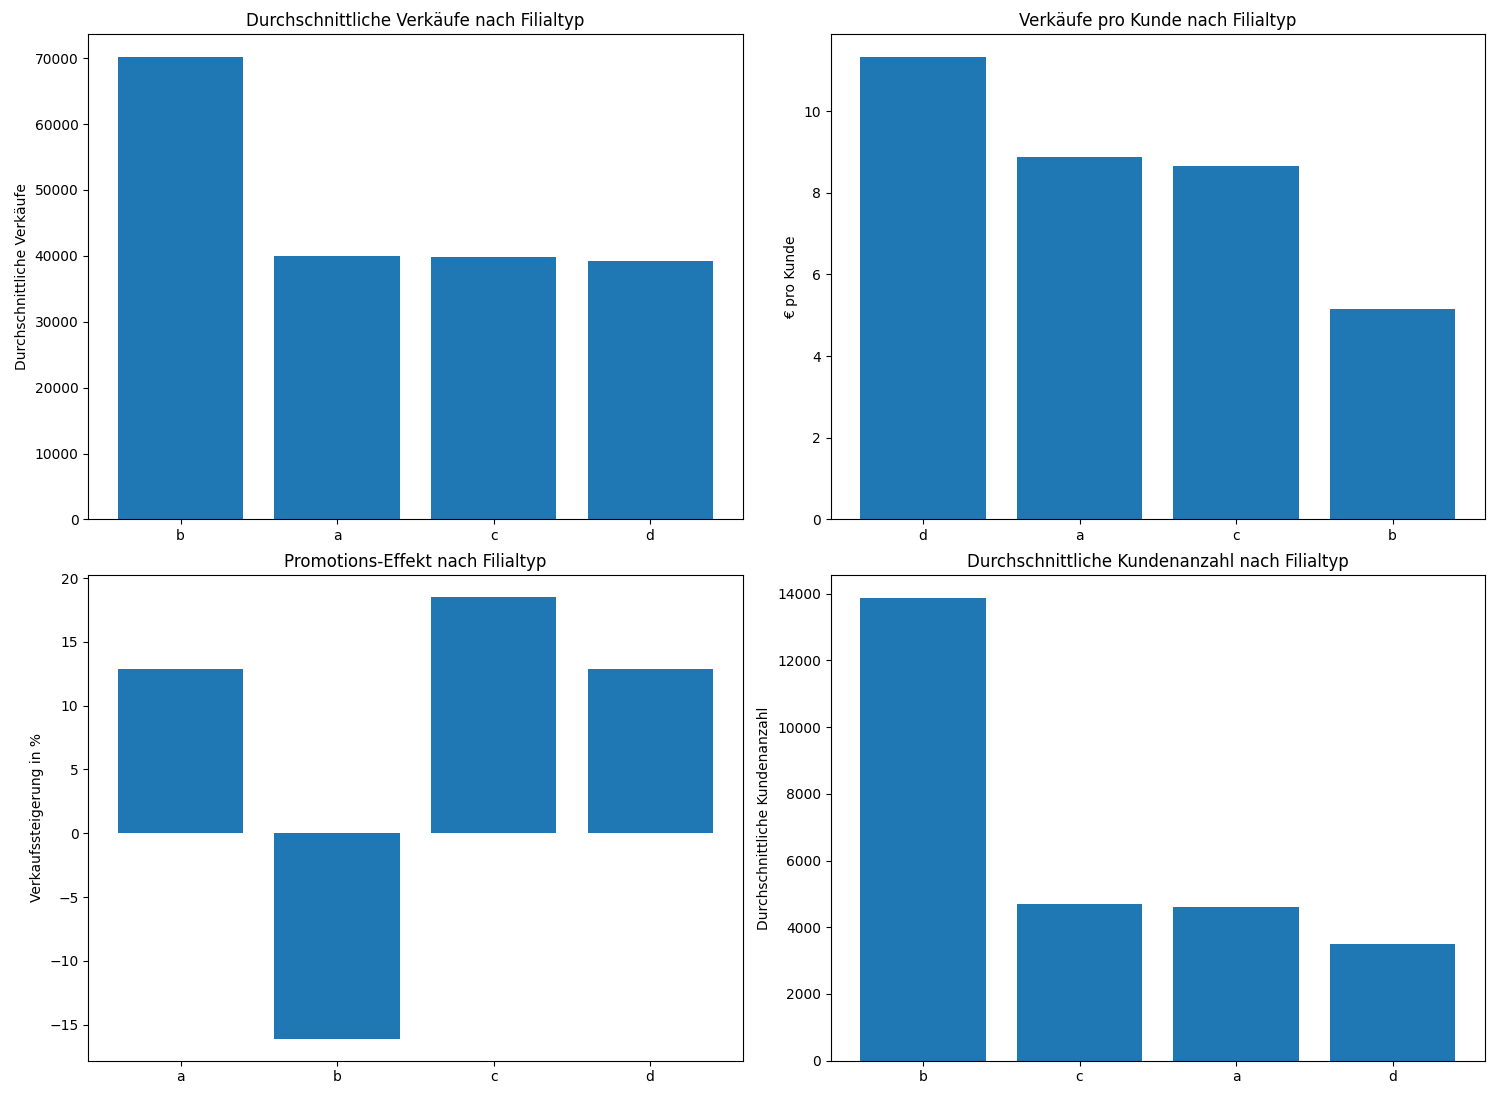

## Verkäufe nach Filialtyp
- Filialtyp B hat mit Abstand die höchsten Verkäufe (70146€ avg)
- andere Filialtypen liegen auf einem ähnlichen Niveau (39000–40000€)
- Hypothese Ladenmodell B hat anderes Geschäftsmodell oder Zielgruppe, die zu deutlich höheren Verkäufen führt
- Ähnlichkeit der Verkäufe bei den anderen Typen deutet darauf hin, dass sie vergleichbare Strategien oder Standorte haben könnten.
- To do: Analysiere die Merkmale von Filialtyp B (Standort, Sortiment, Größe) und Felder finden, die auf andere Filialtypen übertragen werden können

## Verkäufe ro Kunde nach Filialtyp
- Filialtyp D hat die höchsten Verkäufe pro Kunde (11,32 €), gefolgt von A mit 8,88 € und C (8,65 €)
- Filialtyp B hat die niedrigsten Verkäufe pro Kunde (5,16 €), trotz der höchsten Gesamtverkäufe
- Interpretation: Filialtyp B hat zwar hohe Kundenanzahl (siehe unten), aber die Kunden geben im Durchschnitt weniger aus -> Spontankäufe im sinne von "wenn man schonmal da ist", "ach da fällt mir noch ein"
- Filialtyp D hat zwar weniger Kunden, aber diese geben im Durchschnitt mehr aus -> eher teurere Produkte mit höheren Margen (Bio fokus oder Kosmetika, keine Ahnung)
- A/C von allem etwas

## Promotions-Effekte nach Filialtyp
- Filialtyp C stärkste Verkaufssteigerung durch Promotions (18%), Filialtyp B hat eine negative Verkaufssteigerung (-15%), was darauf hindeutet, dass Promotions hier nicht effektiv sind (Übersättigung?)
- A und D Filialen mit moderate Steigerungen (10% und 12%)
- Promotions wirken sich unterschiedlich aus. Bei Typ B vielleicht schlecht umgesetzt (nciht zielgerichtet) oder die Zielgruppe nicht ansprechen (Sortiment, Produktauswahl)
- Filialen C profitieren am meisten -> vielleicht preissensible Kundengruppe?
To Do: Promotionsstrategie für Typ B überprüfen und ggf an die Zielgruppe anpassen. Promotions für C gezielt nutzen, da sie heir besonders Effektiv sind.

## Kundenanzahl nach Ladenmodell
- Filialtyp B hat mit Abstand die höchste durchschnittliche Kundenanzahl (13861), andere Filialtypen haben deutlich weniger Kunden (3.490–4.693)
- Filialtyp B scheint in stark frequentierten Gebieten zu liegen oder ein breiteres Publikum anzusprechen
- andere Filialen haben zwar geringere Kundenanzahl, könnten aber gezielter auf eine bestimmte Zielgruppe ausgerichtet sein
- Analysiere die Standorte und Zielgruppen von Typ B, um die hohe Kundenanzahl zu erklären
- Überlege, wie die Kundenanzahl bei den anderen Typen gesteigert werden kann (z. B. durch Marketing oder Standortoptimierung)

## Promotions
Alle haben gleiche Promotionshäufigkeit (0.38) -> Zerntrale Strategie, hier ist Potential für Anpassungen unter Berücksichtigung Filialspezifischer Charakteristika

## Erste Handlungsempfehlungen:
- für B: Sortiment überprüfen um höhere Margen zu erzielen (Kunden sind ja da)
- Typ D: Hier ist das Sortiment aber weniger Kunden -> Steigerung der Frequenz/Kundenbindung durch gezielte Promotions der best seller
- A/C: Gibt es mechanismen aus A und D, die sich hier anwenden lassen? 

# 3.2 Promotionsseffekte

In [6]:
########################## Analyse der Promotionseffekte

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))

###Verkäufe mit/ohne Promotion und Filialtyp
promo_effect = store_performance.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack()
width = 0.35
x = np.arange(len(promo_effect.index))

ax1.bar(x - width/2, promo_effect[0], width, label='Ohne Promo')
ax1.bar(x + width/2, promo_effect[1], width, label='Mit Promo')
ax1.set_title('Verkäufe mit/ohne Promotion nach Filialtyp')
ax1.set_xticks(x)
ax1.set_xticklabels(promo_effect.index)
ax1.set_ylabel('Durchschnittliche Verkäufe (€)')
ax1.legend()

#
promo_increase = ((promo_effect[1] - promo_effect[0]) / promo_effect[0] * 100).round(1)
ax2.bar(promo_effect.index, promo_increase)
ax2.set_title('Verkaufssteigerung durch Promotion')
ax2.set_ylabel('Steigerung in %')

plt.tight_layout()
plt.show()

### detaillierte Ausgabe
print("\nPromotionseffekte nach Filialtyp:")
for store_type in store_performance['StoreType'].unique():
    type_data = store_performance[store_performance['StoreType'] == store_type]
    no_promo = type_data[type_data['Promo'] == 0]['Sales'].mean()
    with_promo = type_data[type_data['Promo'] == 1]['Sales'].mean()
    increase = ((with_promo - no_promo) / no_promo * 100).round(1)

    print(f"\nFilialtyp {store_type}:")
    print(f"Ohne Promotion: {no_promo:.2f}€")
    print(f"Mit Promotion: {with_promo:.2f}€")
    print(f"Steigerung: {increase}%")

NameError: name 'plt' is not defined

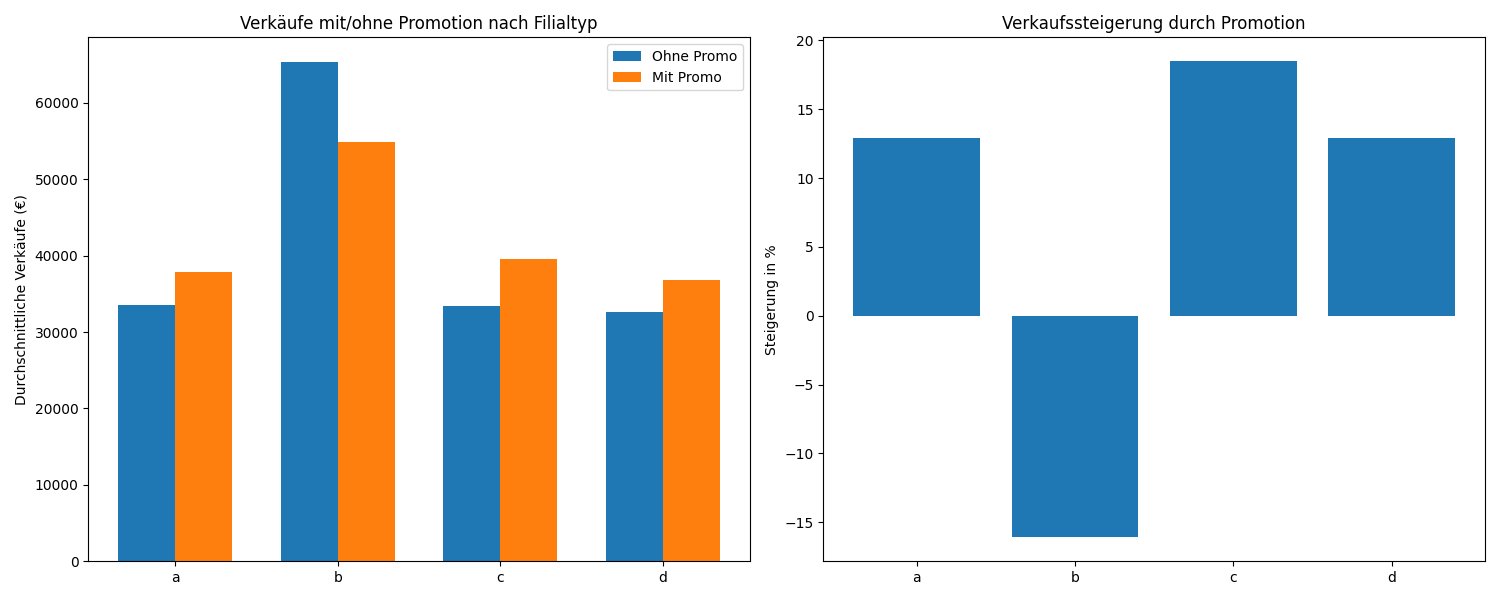

## Analyse der Promotions
- Filialtyp C zeigt den größten Unterschied zwischen Verkäufen mit und ohne Promotion. Verkäufe steigen von 33448€ auf 39628€ (+18,5%)
- A und D zeigen ebenfalls eine deutliche Steigerung durch Promotions (12,9%)
- Filaaltp B zeigt negative Auswirkung von Promotions: Die Verkäufe sinken von 65315€ auf 54829€ (-16,1%).
- Interpretation: Promotions sind bei den Filialtypen A, C und D effektiv, da  die Verkäufe signifikant steigen. Bei Filialtyp B verfehlen sie ihre Wirkung aber und sind kontraproduktiv -> falsche Zielgruppenansprache, ineffektive Promotionsstrategien, Kundenverhalten während Promotions unersuchen, Sortiment,  Wöchentliche Muster vs. Promotions Timing?!

## Handlungsempfehlunen:

- Überprüfung der Promotionsstrategie in Typ-B-Filialen
- Ausweitung der Promotionsaktivitäten in Typ-C-Filialen
- Beibehaltung der bewährten Promotionsstrategie in Typ-A- und Typ-D-Filialen
- Analyse der erfolgreichen Promotionskonzepte in Typ-C-Filialen
- Entwicklung filialtypenspezifischer Promotionsstrategien
- Überprüfung der Kannibalisierungseffekte in Typ-B-Filialen
- Entwicklung eines differenzierten Promotionsansatzes je nach Filialtyp
- Fokus auf Typ-C-Konzepte als Best-Practice-Beispiele
- Grundlegende Neuausrichtung der Promotionsstrategie für Typ-B-Filialen

## 3.2.1. Ladenmodell B

In [ ]:
# Kundenverhalten währedn Promotions
type_b_analysis = store_performance[store_performance['StoreType'] == 'b'].groupby('Promo').agg({
    'Sales': ['mean', 'std'],
    'Customers': ['mean', 'count'],
    'SalesPerCustomer': 'mean'
}).round(2)

# Vergleich Kundenfrequenz vs Durchschnittskäufe
print("Detailanalyse Typ-B-Filialen während Promotionen:")
print(type_b_analysis)

In [ ]:
# Promotionseffekte nach Wochentag
weekly_promo_effect = store_performance[store_performance['StoreType'] == 'b'].groupby(['DayOfWeek', 'Promo']).agg({
    'Sales': 'mean',
    'Customers': 'mean'
}).round(2)

print("\nPromotionseffekte nach Wochentag für Typ-B:")
print(weekly_promo_effect)

## Umsatz- und Kundenstruktur
B Filialen haben generellschon höchste Umsatzniveaus (65.314€ ohne Promotion) und die Kundenfrequenz ist deutlich höher als bei anderen Filialtypen (13.399 Kunden ohne Promotion). ABER der Umsatz pro Kund*in ist mit 4,98€ niedriger als bei den anderen Ladenmodellen

## Auffällige Promotionsmuster
Bei aktiver Promotion sinkt der Umsatz um 16,1% 

## Hypohthesen:
- Kunden verschieben Großeinkäufe auf Promotionszeiten (wobei die steigerung von 4,98 auf max 5,64 nicht gerade ein Großeinkauf ist)
- Übersättigung bei umfassenden Promos "Promotionsmüdigkeit"
- Deutlicher Rückgang der Kundenfrequenz bei voller Promotion (-26%)
- Leicht höhere Ausgaben pro Kunde kompensieren nicht den Frequenzrückgang
- Strukturelle Besonderheiten berücksichtigen -> Typ-B-Filialen haben ein anderes Grundniveau (fast doppelt so hohe Umsätze)
    Möglicherweise andere Kundenstruktur/sozioökonomisches Umfeld

## Handlungsempfehlungen:

Optimierung der Promotionsintensität:
- Vermeidung von dauerhaften Promotionen
- promotionsplanung mit Best seller Produkten und einzelne gezielte Aktionen um Impulskäufe mit zu nehmen

Kundenfrequenz:
- Maßnahmen zur Stabilisierung der Kundenfrequenz während Promotionen via Bonusprogamme
- Kundenbindung und gezielte Ansprache der "Stammkunden"

Sortiment:
- Überprüfung der Promotionsartikel
- Balance zwischen Basis- und Aktionssortiment
- Fokus auf frequenzgenerierende Artikel

# 4. Korrelationsmatrix der Wichtigsten Features als Entscheidungshilfe zur Featuresauswahl

- Kundenanzahl (Customers) 0,89: stärkste Korrelation mit den Verkäufen. Soweit erwartbar, da mehr Kunden in der Regel zu höheren Verkäufen führen -> deutet darauf hin, dass diese bneiden Variablen eng miteinander verbunden sind

- Promo 0,45: Promotions haben eine positive Korrelation mit den Verkäufen. Zeigt, dass Promotions Verkäufe steigern, trotzdem ist der Effekt ist nicht so stark wie bei der Kundenanzahl. Beziehung zwischen den Features Promo und Customers daher nicht ganz so stark

- SchoolHoliday 0,09: Schulferien haben schwach positive Korrelation mit den Verkäufen

- DayOfWeek (-0.46): Moderate negative Korrelation -> Verkäufe sinken zum Wochenende hin

## Weitere Beobachtungen:
- Customers und Open sind beide stark mit Sales korreliert und auch untereinander (0.62)
- DayOfWeek zeigt negative Korrelationen mit fast allen Features
- SchoolHoliday hat generell sehr schwache Korrelationen mit allen Features

In [ ]:
################################################## Heatmap als Entscheidungshilfe für erste Featureasuwahl

def heatmap(df):

    #numerische Spalten
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    #Heatmap
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 8))

    sns.heatmap(corr_matrix,
                annot=True,  
                cmap='coolwarm',  
                center=0,  
                fmt='.2f',  
                square=True, 
                linewidths=0.5)  

    plt.title('Korrelationsmatrix der numerischen Features', pad=20)
    plt.tight_layout()
    plt.show()

    sales_corr = corr_matrix['Sales'].sort_values(ascending=False)  ##ausgabe der korrelation aufdie Sales
    print("\nKorrelationen mit Sales:")
    print(sales_corr)

heatmap(train_df)

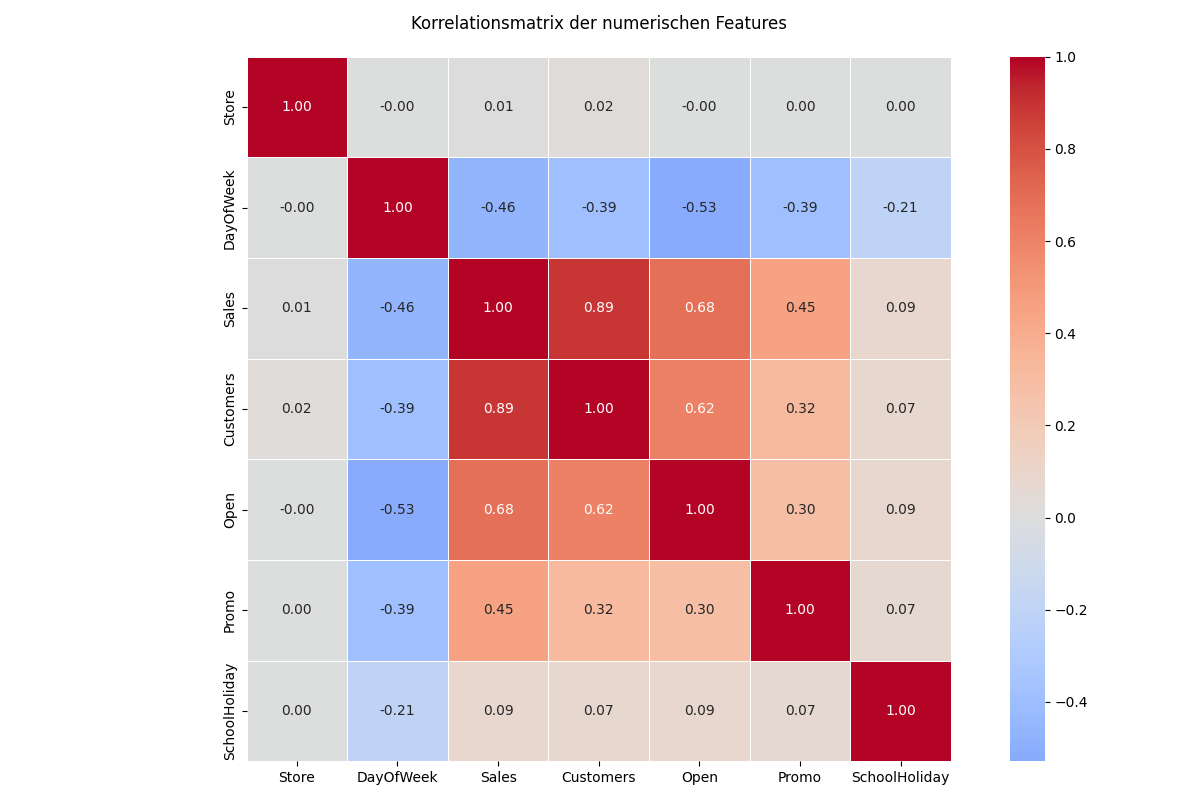

# Part 4: Features (Basisfeatures)


Zeitliche Muster:
- Wochentags-Effekte (Montag stark, Samstag schwach, Sonntag nix)
- Saisonale Effekte
- Feiertage und Schulferien (aus StateHoliday und SchoolHoliday)

Ladenmodelle:  
- Filialtypen mit unterschiedlichen Grundniveaus haben Einfluss auf Verkäufe bzw. das Einkaufsverhalten der Kunden
- Sortiment
- Wettbewerbssituation (CompetitionDistance)

Promotions
- zusammenhang zwischen StoreType und Promotion
- Unterschiedliche Wirkung je nach Filialtyp
- Promo und Promo2 Informationen
- PromoInterval für wiederkehrende Promotions

Kunden und Verkaufszahlen:
SalesPerCustomer bildet die kaudfkraft der einzelnen Kunden ab, Einfluss auf dei Performance der Filiale (Standort, sozioökonomische Kundenstruktur)


Auswahl nach:
- Geschäftsrelevanz -> Einflussfaktoren auf Verkäufe
- Erfassen veschiedene Kundenverhalten
- Gut abzubilden in den Modellen

## Feature Refinement (Advanced Features)

Die wichtigsten Features laut Feature Importance sind (siehe auch weiter unten):
- DayOfWeek
- Promo
- CompetitionDistance
- StoreType_Encoded
- Features, die wenig bis gar keinen Einfluss haben (Promo_Weekend, IsWeekend, IsHighSeason)

Advanced Features:
- Interaktionen zwischen wichtigen Features (Promo und DayOfWeek)
- Zeitbasierte Features wie Sales_Lag (Verkäufe der letzten Woche) oder durchschnittliche Sales (Sales_MA)
- Unwichtige Features entfernen, da kein Einflsuss auf die Vorhersage
- Features werden pro Store erstellt -> erfassen store-spezifischer Muster
- Fehlende Werte behandeln (Store-Durchschnitt)


In [ ]:
################################################Feature Engineering Basic


# TRain und Testdaten mergen
train_df = train_df.merge(store_df, on='Store', how='left')

# zeitliche Features auswählen
# wir haben oben bei der EDA einen Zeitlichen zusammenhang gesehen
train_df['Date'] = pd.to_datetime(train_df['Date'])  #datum in datetime
train_df['Year'] = train_df['Date'].dt.year          
train_df['Month'] = train_df['Date'].dt.month        
train_df['Week'] = train_df['Date'].dt.isocalendar().week  

# Store-Typen in Zahlen umwandeln
# verschiedene Ladenmodelle perfomen anders
train_df['StoreType_Encoded'] = train_df['StoreType'].map({
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3
})

# Gleiches für Sortiment (kann eigentlich weg)
train_df['Assortment_Encoded'] = train_df['Assortment'].map({
    'a': 0,
    'b': 1,
    'c': 2
})

# weitere Features erstellen
train_df['IsWeekend'] = (train_df['DayOfWeek'].isin([6,7])).astype(int)

train_df['IsHighSeason'] = (train_df['Month'].isin([11,12])).astype(int)   ###HighSeason = November/Dezemebr

# Wie weit/nah ist die Konkurrenz ansässig? (kleiner als Median der Konkurrenzdistanz)
median_distance = train_df['CompetitionDistance'].median()
train_df['HasNearCompetition'] = (train_df['CompetitionDistance'] < median_distance).astype(int)

# Promotion Features
# Kombination aus Promo und Wochenende
train_df['Promo_Weekend'] = train_df['Promo'] * train_df['IsWeekend']

# Featureliste erstellen
selected_features = [
    'Store',
    'DayOfWeek',
    'Promo',
    'SchoolHoliday',
    'StoreType_Encoded',
    'Assortment_Encoded',
    'CompetitionDistance',
    'IsWeekend',
    'HasNearCompetition',
    'IsHighSeason',
    'Month',
    'Year',
    'Promo_Weekend',
    'Customers',                                    # Erweitert um Customers (sollte auch in Feature importance dabei sein)
    'Sales_per_Customer'                           # 
]


################################################################################################## Features Überprüfen

#Zusammenhang Promo, DayOfWeek und Sales 
print("\nDurchschnittliche Sales nach Wochentag und Promo:")
avg_sales = train_df.groupby(['DayOfWeek', 'Promo'])['Sales'].mean().unstack()
print(avg_sales)

#
plt.figure(figsize=(12, 6))
avg_sales.plot(kind='bar', width=0.8)
plt.title('Durchschnittliche Sales nach Wochentag und Promo')
plt.xlabel('Tag der Woche')
plt.ylabel('Durchschnittliche Sales')
plt.legend(['Keine Promo', 'Promo'])
plt.tight_layout()
plt.show()

# nochmal heatmap jetzt mit wichtigsten Features (jetzt mit StoreType)
correlation_features = ['Sales', 'DayOfWeek', 'Promo', 'CompetitionDistance',
                       'StoreType_Encoded', 'Month']
correlation_matrix = train_df[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korrelationsmatrix der wichtigsten Features')
plt.tight_layout()
plt.show()



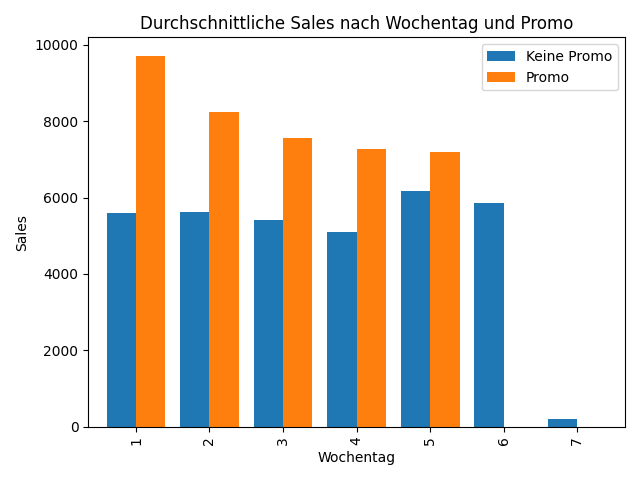

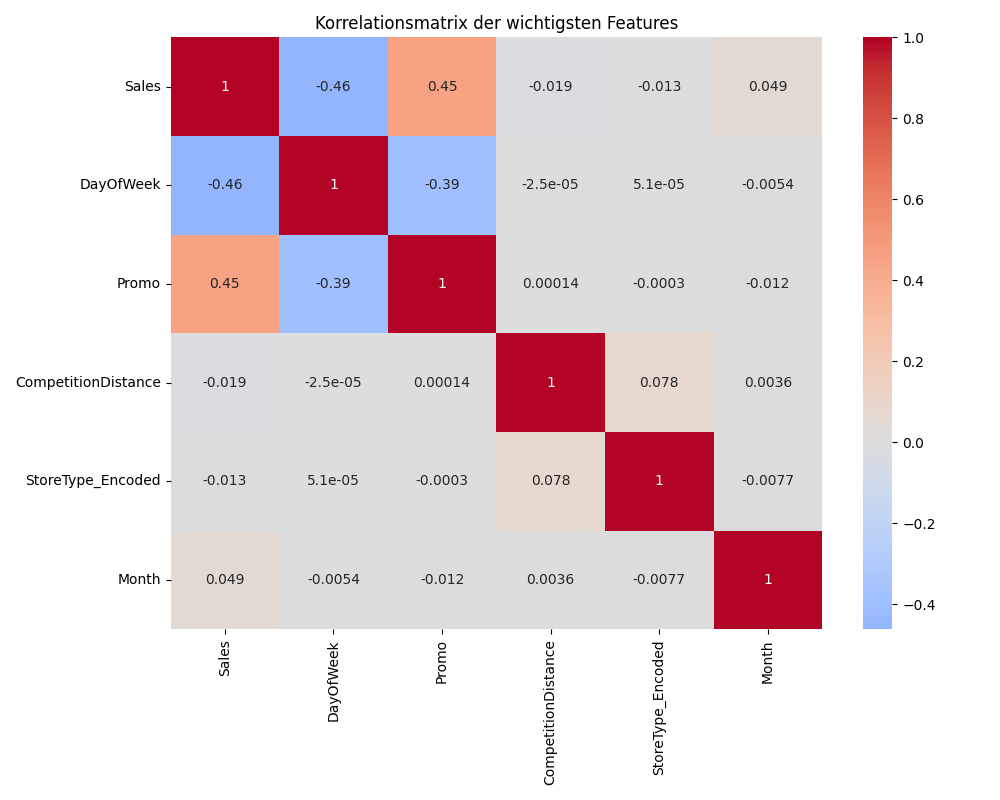

- Promo und DayOfWeek haben moderate Korrelation mit den Verkäufen
- geringe korrelation zwischen CompetitionDistance und StoreType kann dennoch Informationen liefern
- Month eine schwache positive Korrelation mit den Verkäufen hat -> saisonale Effekte hinweist

In [ ]:
############################################################################ 
#####Erweitertes Feature Engineering um Vorhersagen zu verbessernb


# Features von oben
train_df['Promo_DayOfWeek'] = train_df['Promo'] * train_df['DayOfWeek']
store_avg_sales = train_df.groupby('Store')['Sales'].mean()
train_df['Store_Avg_Sales'] = train_df['Store'].map(store_avg_sales)
dow_avg_sales = train_df.groupby('DayOfWeek')['Sales'].mean()
train_df['DayOfWeek_Avg_Sales'] = train_df['DayOfWeek'].map(dow_avg_sales)

# zeitbasierte Features

# sortieren nach Store und Datum
train_df = train_df.sort_values(['Store', 'Year', 'Month', 'DayOfWeek'])

# Verkäufe der letzten 7 Tage
train_df['Sales_Lag7'] = train_df.groupby('Store')['Sales'].shift(7)
## fehlende Werte mit Durchschnitt Stores
train_df['Sales_Lag7'].fillna(train_df['Store_Avg_Sales'], inplace=True)
# und letzte 7 bzw 14 Tage
train_df['Sales_MA7'] = train_df.groupby('Store')['Sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
train_df['Sales_MA14'] = train_df.groupby('Store')['Sales'].transform(
    lambda x: x.rolling(window=14, min_periods=1).mean()
)

## Veränderung zum gleichen Tag der Vorwoche
train_df['Sales_RelativeChange'] = (train_df['Sales'] - train_df['Sales_Lag7']) / train_df['Sales_Lag7']
train_df['Sales_RelativeChange'].replace([np.inf, -np.inf], 0, inplace=True)
train_df['Sales_RelativeChange'].fillna(0, inplace=True)

# Featureliste erweitern um:
selected_features.extend([
    'Promo_DayOfWeek',
    'Store_Avg_Sales',
    'DayOfWeek_Avg_Sales',
    'Sales_Lag7',
    'Sales_MA7',
    'Sales_MA14',
    'Sales_RelativeChange'
])

# Features und Target definieren
X = train_df[selected_features]    ##features
y = train_df['Sales']              ##target

# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Feature importance (mit Customer)

Costomer jetzt das Wichtigste Feature
- erwartbar, da es ja auch nur Umsatz geben kann, wenn Kunden da sind
- außerdem haben wir oben in der Heatmal die Korrelation gesehen

StoreType
- verscheidene Ladenmodelle generieren andders Umsatz

Konkurrenz
- ist auch erwartbar, wenn Konkurenz qweit weg besser für Umsatz

Promotions
- Standortspezifische Faktoren sind sehr wichtig
- Lokaler Wettbewerb hat signifikanten Einfluss
- Jeder Store hat eigene Charakteristika

DayOfWeek (war vorher weiter vorne)
- Bestätigt die starken Wochenmuster in den Verkaufsdaten
- Montag zeigt höchste Verkäufe

## weitere Customer Features
Damit Customers nicht so dominant ist, könnte man noch weitere Features mit Customer anlegen, um das weiter aufzuschlüsslen
- Sales und Customers
- Promo und Customers
- Sales und Promo
- Sales und DayOfWeek

In [ ]:
def plot_feature_importance(model, X_train):

    importances = model.feature_importances_
    feature_names = X_train.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title('Feature Importance mit Customers', pad=20)
    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print("\nFeature Importance Ranking:")
    print(importance_df.to_string(index=False))


# nur für Radnom Forest
rf_model = results['Random Forest']['model']

plot_feature_importance(rf_model, X_train)

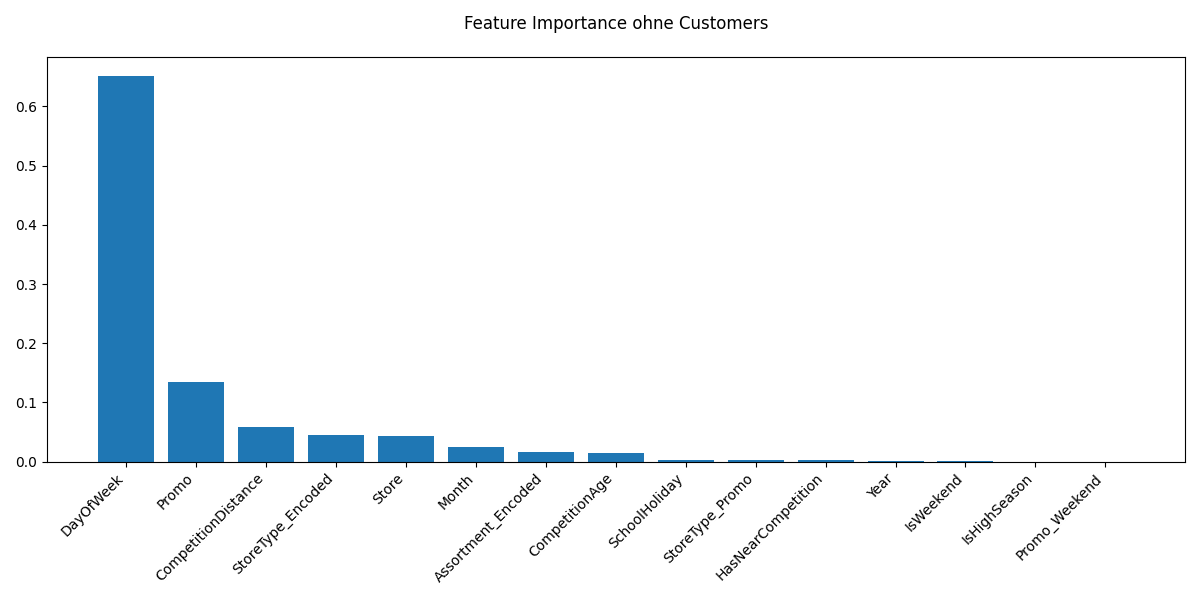

Hier das "alte" Feature Importance noch ohne Customer
- DayOfWeek
- dann Promo
- gefolgt von den Competiotors und StoreType die einen Moderaten Effekt haben


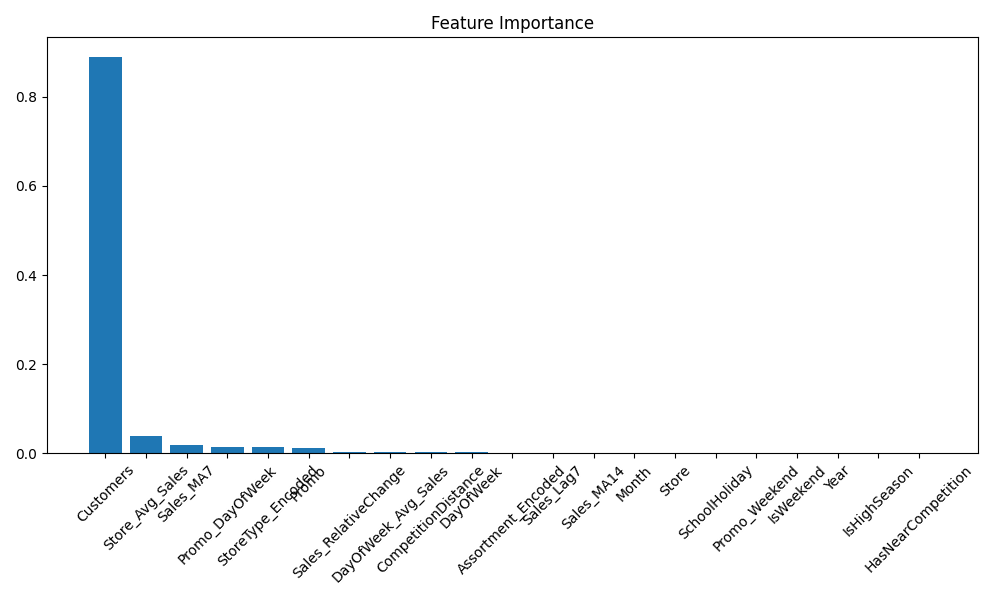

- Jetzt mit Customer Features überlagert die anderen Features deutlich
- dann Sales der StoreTypes
- Sales vom gleichen Tag vor 7 Tagen
- Promo
- und natrülich der StoreType (performen ja alle unterschiedlich)

# Part 5: Modelling

## Modellvergleich Linear Regression vs. Random Forest vs. Gradient Boost Regressor

Der Random Foreest liefert hier die besten Werte und hat sowohl auf den Trainings als auch auf den Testdaten die niedrigsten Fehlerwerte und die höchste Erklärungskraft. Mit den Basisfeatures allerdings nur einen R°2 von 0.59 (nur etwa 59 % der Varianz in den Verkaufszahlen is. Um das zu verbessern, wurden weitere Features ausgewählt (Feature refinement) und die Hyperparameter des Modells zu verändert (Hyperparametertuning).

Random Forest Performance ohne Optimierung:
- Training RMSE: 2471.91
- Test RMSE: 2475.04
- Training R²: 0.59
- Test R²: 0.59
- Training MAE: 1642.75
- Test MAE: 1642.17

## Feature Engineering verbessern

Die wichtigsten Features wurden weiter oben bereits identifiziert (Customers, DayOfWeek, Promo, CompetitionDistance, StoreType). Gleichzeitig nutzen wir noch Features, die kaum Einfluss haben (Promo_Weekend, IsWeekend, IsHighSeason). 

## Hyperparameter-Tuning

Für Random Forest Hyperparameter optimieren, um die Performance zu verbessern:
- Erhöhe die Anzahl der Bäume (n_estimators), z. B. auf 100 oder 200.
- Optimiere die maximale Tiefe (max_depth) und die minimale Anzahl an Blättern (min_samples_leaf)
- wobei mehr Bäume, die Tiefe Ausgleichen können und bei sehr Tiefen Bäumen kann geringere Anzahl Bäume ausreichen
- Beziehung zwischen hohen min_sample_leaves, kann große max_depth erlauben 

## Nach Optimierung
Dadurch können nach Feature erweiterung und Modelloptimierungen die Vorhersagewerte des Random Forrest deutlich verbessert werden:

Linear Regression Performance:
- Training RMSE: 1227.61
- Test RMSE: 1224.70
- Training R²: 0.90
- Test R²: 0.90
- Training MAE: 828.95
- Test MAE: 830.17

Random Forest Performance:
- Training RMSE: 803.80
- Test RMSE: 808.00
- Training R²: 0.96
- Test R²: 0.96
- Training MAE: 512.81
- Test MAE: 517.11

Gradient Boosting Performance:
- Training RMSE: 1724.43
- Test RMSE: 1725.84
- Training R²: 0.80
- Test R²: 0.80
- Training MAE: 1273.59
- Test MAE: 1275.30

In [ ]:
####################################################################### MODELLING 

X = train_df[selected_features]  # von Featuresliste
y = train_df['Sales']           # Zielvariable

# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelloptimierung händisch durchprobieren und nicht via GridSearch
models = {
    'Linear Regression': LinearRegression(
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,      # anzahl Bäume -> 100 bis 200
        max_depth=10,         # tiefe
        min_samples_leaf=2,   # Mindestanzahl von Samples pro Blattn 
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,      # Bäume
        learning_rate=0.1,    # Lernrate = korrektur vorheriger fehler
        max_depth=5,          # nicht so tief Rüdiger
        min_samples_leaf=2,   # Samples pro Blatt
        random_state=42
    )
}

results = {}

# wir vergleichen 3 Modelle...
for name, model in models.items():

    model.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Perfomance berenchne
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'model': model
    }

    print(f"{name} Performance:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.2f}")
    print(f"Test R²: {test_r2:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")


print("\nModellvergleich:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Train RMSE: {metrics['train_rmse']:.2f}, Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Train R²: {metrics['train_r2']:.2f}, Test R²: {metrics['test_r2']:.2f}")
    print(f"Train MAE: {metrics['train_mae']:.2f}, Test MAE: {metrics['test_mae']:.2f}")

## Metriken

Delta zwischen Train und Test zeigt, dass das Modell gut generalisiert und keinen Overfitting kommt.

RMSE Train vs. Test mit 2.25 ist die Differenz ist sehr klein, was darauf hinweist, dass das Modell sowohl auf den Trainings- als auch auf den Testdaten ähnlich gut performt.

R² Train vs. Test: 0.0001: Auch hier ist die Differenz minimal, was zeigt, dass das Modell die Varianz in den Daten sowohl im Training als auch im Test fast gleich gut erklärt.

In [ ]:
############################# Overfitting prüfen

print("\nOverfittinganalyse")

train_rmse = np.sqrt(mean_squared_error(y_train, models['Random Forest'].predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, models['Random Forest'].predict(X_test)))
train_r2 = r2_score(y_train, models['Random Forest'].predict(X_train))
test_r2 = r2_score(y_test, models['Random Forest'].predict(X_test))

## delta zwischen train und test:
rmse_diff = abs(train_rmse - test_rmse)
r2_diff = abs(train_r2 - test_r2)

print(f"RMSE-Differenz (Train vs Test): {rmse_diff:.2f}")
print(f"R²-Differenz (Train vs Test): {r2_diff:.4f}") 

## im Idealfall möglichst klein weist auf gute Generalisierung hin

### Overfitting-Analyse für Random Forest ###

#Differenz-Analyse:
#RMSE-Differenz (Train-Test): 4.20
#R²-Differenz (Train-Test): 0.0003

# Handlungsempfehlungen

Basierend auf den Ergebnissen und der Analyse der Modellleistung sowie der Bedeutung der Features (Promotionen, Ladentypen, zeitbasierte Muster):
 
## Promotions gezielt einsetzen
Die Analyse zeigt, dass Promotionen einen signifikanten Einfluss auf die Verkaufszahlen haben. Daher sollten Promotionen strategisch geplant und optimiert werden:

- Promotions auf Kundenbindung ausrichten, da wir gesehen haben, dass Customers am Stärksten mit den Sales korreliert
- daher speziell in Kombination mit anderen Maßnahmen einsetzen, bspw: Promotionen könnten mit anderen Marketingmaßnahmen wie Rabatten, Treueprogrammen oder saisonalen Kampagnen kombiniert werden, um die Effekt zu maximieren und Kunden zu animieren
- Gezielte Planung von Promotionen Wochentagseffekte einplanen. Wenn bestimmte Tage wie Montag, Dienstag oder Freitag besonders profitabel sind, sollten Promotionen auf diese Tage konzentriert werden
- Regionale Unterschiede berücksichtigen: Da die Wirkung von Promotionen möglicherweise von Store zu Store unterschiedlich ist, sollten regionale gegebenheiten berückscihtigt werden, um maßgeschneiderte Promotion-Strategien zu entwickeln
- Optimierung der Lagerbestände: Während Promotionen laufen, sollten Filialen sicherstellen, dass ausreichend Lagerbestand vorhanden ist, um die erhöhte Nachfrage zu decken
- Personalplanung anpassen: Während Promotionen könnte es zu einem Anstieg des Kundenverkehrs kommen. Filialen sollten sicherstellen, dass genügend Personal verfügbar ist

## Ladentypen und Filialstrategien
Die Ergebnisse zeigen, dass der Ladentyp (StoreType) und die durchschnittlichen Verkaufszahlen pro Store (Store_Avg_Sales) wichtige Prädiktoren für die Verkaufsleistung sind. Dies deutet darauf hin, dass unterschiedliche Ladentypen unterschiedliche Strategien erfordern.

- Individuelle Strategien für Ladentypen entwickeln: Große Stores könnten von umfangreicheren Promotionen und einem breiteren Produktsortiment profitieren, kleinere Stores könnten sich auf Nischenprodukte oder spezifische Zielgruppen konzentrieren
- Investitionen priorisieren: Stores mit konstant hohen Verkaufszahlen (Store_Avg_Sales) könnten priorisiert werden, wenn es um Investitionen in Infrastruktur, Marketing oder Personal geht
- Schwache Stores unterstützen: Stores mit niedrigen durchschnittlichen Verkaufszahlen könnten durch gezielte Maßnahmen wie lokale Promotionen oder Standortanalysen unterstützt werden
- Filialleiter sollten die Verkaufsdaten ihrer Stores regelmäßig analysieren, um zu verstehen, welche Produkte und Promotionen bei ihren Kunden am besten ankommen
- Anpassung des Sortiments: Basierend auf den Verkaufsdaten könnten Filialen ihr Sortiment an die Bedürfnisse der lokalen Kunden anpassen -> wenn das Sortiment für die jeweilige Kundengruppe relevant ist kommen mehr Kunden

## Zeitbasierte Muster nutzen
Die zeitbasierten Features zeigen dass es klare Muster in den Verkaufszahlen gibt, die sich auf wöchentliche und saisonale Trends beziehen.

- Saisonale Trends berücksichtigen: Verkaufszahlen scheinen von wöchentlichen und saisonalen Mustern beeinflusst zu werden. Muster nutzen um saisonale Kampagnen (vor Feiertagen oder in der Ferienzeit) zu planen
- Vorbereitung auf wöchentliche Schwankungen: Filialen sollten sich auf wiederkehrende wöchentliche Muster vorbereiten
- Flexibilität bei der Personalplanung: Basierend auf den zeitbasierten Mustern könnten Filialen ihre Personalplanung anpassen, um Stoßzeiten besser zu bewältigen